MOST_OUTLIERS: Securities Account
PAIR: ('Age', 'Experience')
REMOVE: ZIP Code
EXP_MEAN: 23.196
CC_MEAN: 23.062
BOXPLOT_FEATURE: Income
ZCOUNT: 2
ROWS_LEFT: 3998
GINI_F1: 0.885
ENTROPY_F1: 0.896
GINI_BAL_F1: 0.883
ENTROPY_BAL_F1: 0.913
SHARE0: 0.904
N1_SMOTE: 2891
GINI_SMOTE_F1: 0.859
ENTROPY_SMOTE_F1: 0.825


c:\Users\Misha\PycharmProjects\itmo_ml_moodle\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Misha\PycharmProjects\itmo_ml_moodle\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


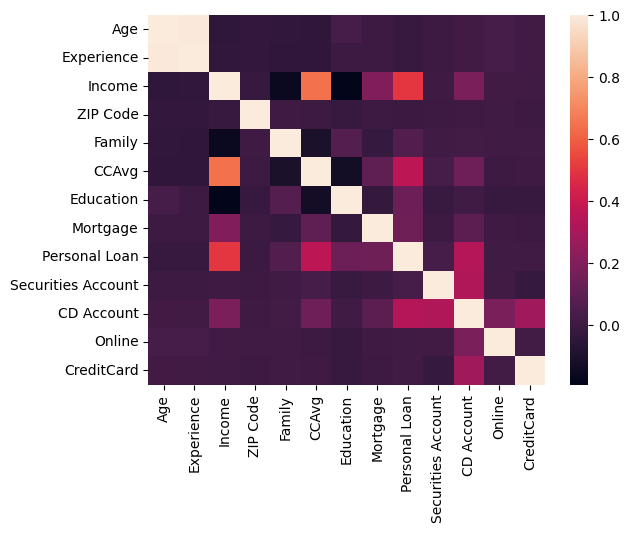

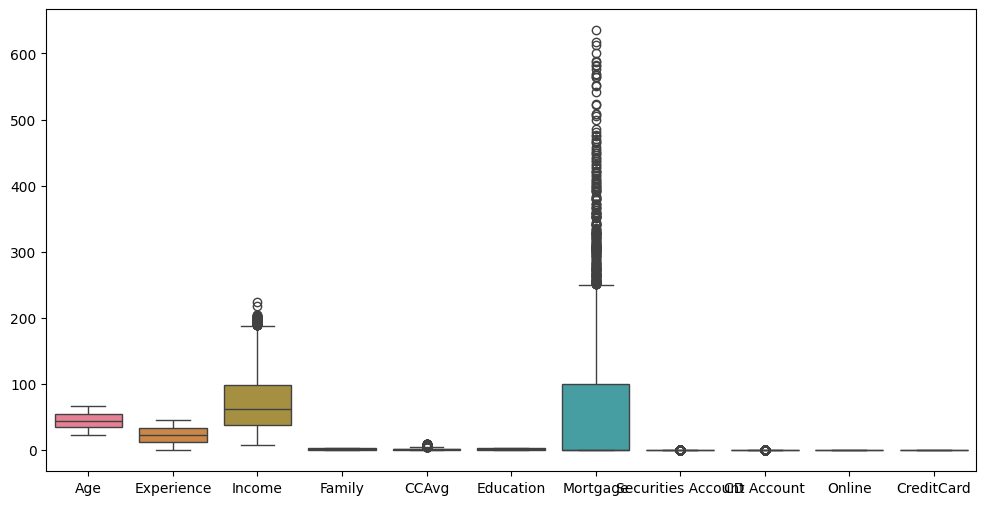

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("./Bank_Personal_Loan_Modelling_train.csv")
num_cols = df.drop(columns=["Personal Loan"]).columns

outlier_counts = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    outlier_counts[col] = ((df[col] < low) | (df[col] > high)).sum()

max_outliers_feature = max(outlier_counts, key=outlier_counts.get)
print("MOST_OUTLIERS:", max_outliers_feature)

df = df.drop(columns=["ID"])

corr = df.corr()
sns.heatmap(corr)

abs_corr = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool))
pairs = abs_corr.stack().sort_values(ascending=False)
max_pair = tuple(sorted(pairs.index[0]))
print("PAIR:", max_pair)

corr_target = corr["Personal Loan"].abs().drop("Personal Loan")
min_corr_feature = corr_target.idxmin()
print("REMOVE:", min_corr_feature)

df = df.drop(columns=[min_corr_feature])

exp_shift = -df["Experience"].min()
df["Experience"] = df["Experience"] + exp_shift
print("EXP_MEAN:", round(df["Experience"].mean(), 3))

cc_shift = df["CCAvg"] * 12
print("CC_MEAN:", round(cc_shift.mean(), 3))

num_cols = df.drop(columns=["Personal Loan"]).columns
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])

print("BOXPLOT_FEATURE:", "Income")

z = zscore(df["Income"])
n_out = np.sum(np.abs(z) > 3)
print("ZCOUNT:", int(n_out))

df_clean = df[np.abs(z) <= 3]
print("ROWS_LEFT:", df_clean.shape[0])

X = df_clean.drop(columns=["Personal Loan"])
y = df_clean["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=105, stratify=y
)

clf1 = DecisionTreeClassifier(random_state=105, criterion="gini")
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test)
print("GINI_F1:", round(f1_score(y_test, pred1), 3))

clf2 = DecisionTreeClassifier(random_state=105, criterion="entropy")
clf2.fit(X_train, y_train)
pred2 = clf2.predict(X_test)
print("ENTROPY_F1:", round(f1_score(y_test, pred2), 3))

clf3 = DecisionTreeClassifier(random_state=105, criterion="gini", class_weight="balanced")
clf3.fit(X_train, y_train)
pred3 = clf3.predict(X_test)
print("GINI_BAL_F1:", round(f1_score(y_test, pred3), 3))

clf4 = DecisionTreeClassifier(random_state=105, criterion="entropy", class_weight="balanced")
clf4.fit(X_train, y_train)
pred4 = clf4.predict(X_test)
print("ENTROPY_BAL_F1:", round(f1_score(y_test, pred4), 3))

share0 = (y_train == 0).mean()
print("SHARE0:", round(share0, 3))


def simple_smote(X, y, k=5):
    X = np.array(X)
    y = np.array(y)
    X_min = X[y == 1]
    n_min = len(X_min)
    n_maj = len(X[y == 0])
    n_new = n_maj - n_min
    neigh = NearestNeighbors(n_neighbors=k).fit(X_min)
    idx = np.random.randint(0, n_min, size=n_new)
    nn = neigh.kneighbors(X_min[idx], return_distance=False)
    choose = np.random.randint(1, k, size=n_new)
    X_syn = X_min[idx] + np.random.rand(n_new, 1) * (X_min[nn[np.arange(n_new), choose]] - X_min[idx])
    y_syn = np.ones(n_new)
    X_new = np.vstack([X, X_syn])
    y_new = np.concatenate([y, y_syn])
    return X_new, y_new


X_train_sm, y_train_sm = simple_smote(X_train, y_train, k=5)

n_class1 = np.sum(y_train_sm == 1)
print("N1_SMOTE:", int(n_class1))

clf5 = DecisionTreeClassifier(random_state=105, criterion="gini")
clf5.fit(X_train_sm, y_train_sm)
pred5 = clf5.predict(X_test)
print("GINI_SMOTE_F1:", round(f1_score(y_test, pred5), 3))

clf6 = DecisionTreeClassifier(random_state=105, criterion="entropy")
clf6.fit(X_train_sm, y_train_sm)
pred6 = clf6.predict(X_test)
print("ENTROPY_SMOTE_F1:", round(f1_score(y_test, pred6), 3))


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("./Bank_Personal_Loan_Modelling_train.csv")

df = df.drop(columns=["ID"])

corr = df.corr()
abs_corr = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool))
pair = abs_corr.stack().sort_values(ascending=False).index[0]
pair = tuple(sorted(pair))
print("PAIR:", pair)

least = corr["Personal Loan"].abs().drop("Personal Loan").idxmin()
print("REMOVE:", least)

shift = -df["Experience"].min()
df["Experience_shift"] = df["Experience"] + shift
print("EXP_MEAN:", round(df["Experience_shift"].mean(), 3))

df["CC_year"] = df["CCAvg"] * 12
print("CC_MEAN:", round(df["CC_year"].mean(), 3))

num_cols = ['Age','Experience','Income','Family','CCAvg','Education','Mortgage','Securities Account','CD Account','Online','CreditCard']

outlier_counts = {}
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    outlier_counts[col] = ((df[col] < low) | (df[col] > high)).sum()

boxplot_feature = max(outlier_counts, key=outlier_counts.get)
print("BOXPLOT_FEATURE:", boxplot_feature)

zvals = zscore(df[boxplot_feature])
zcount = (np.abs(zvals) > 3).sum()
print("ZCOUNT:", zcount)

rows_left = df.shape[0] - zcount
print("ROWS_LEFT:", rows_left)

X = df[num_cols]
y = df["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=105, stratify=y
)

clf_gini = DecisionTreeClassifier(random_state=105, criterion='gini')
clf_gini.fit(X_train, y_train)
pred = clf_gini.predict(X_test)
print("GINI_F1:", round(f1_score(y_test, pred), 3))

clf_ent = DecisionTreeClassifier(random_state=105, criterion='entropy')
clf_ent.fit(X_train, y_train)
pred = clf_ent.predict(X_test)
print("ENTROPY_F1:", round(f1_score(y_test, pred), 3))

clf_gini_bal = DecisionTreeClassifier(random_state=105, criterion='gini', class_weight='balanced')
clf_gini_bal.fit(X_train, y_train)
pred = clf_gini_bal.predict(X_test)
print("GINI_BAL_F1:", round(f1_score(y_test, pred), 3))

clf_ent_bal = DecisionTreeClassifier(random_state=105, criterion='entropy', class_weight='balanced')
clf_ent_bal.fit(X_train, y_train)
pred = clf_ent_bal.predict(X_test)
print("ENTROPY_BAL_F1:", round(f1_score(y_test, pred), 3))

share0 = (y_train == 0).mean()
print("SHARE0:", round(share0, 3))

n1 = (y_train == 1).sum()
n0 = (y_train == 0).sum()
upsample_n1 = n0
df_train = X_train.copy()
df_train["target"] = y_train

minority = df_train[df_train["target"] == 1]
minority_up = minority.sample(upsample_n1, replace=True, random_state=105)
df_up = pd.concat([df_train, minority_up])
print("N1_UP:", upsample_n1)

X_up = df_up[num_cols]
y_up = df_up["target"]

clf_gini_up = DecisionTreeClassifier(random_state=105, criterion='gini')
clf_gini_up.fit(X_up, y_up)
pred = clf_gini_up.predict(X_test)
print("GINI_UP_F1:", round(f1_score(y_test, pred), 3))

clf_ent_up = DecisionTreeClassifier(random_state=105, criterion='entropy')
clf_ent_up.fit(X_up, y_up)
pred = clf_ent_up.predict(X_test)
print("ENTROPY_UP_F1:", round(f1_score(y_test, pred), 3))


PAIR: ('Age', 'Experience')
REMOVE: ZIP Code
EXP_MEAN: 23.196
CC_MEAN: 23.062
BOXPLOT_FEATURE: Securities Account
ZCOUNT: 0
ROWS_LEFT: 4000
GINI_F1: 0.903
ENTROPY_F1: 0.889
GINI_BAL_F1: 0.924
ENTROPY_BAL_F1: 0.926
SHARE0: 0.904
N1_UP: 2893
GINI_UP_F1: 0.907
ENTROPY_UP_F1: 0.933


In [12]:
model4 = DecisionTreeClassifier(random_state=105, criterion='entropy', class_weight='balanced')
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)
print("ENTROPY_BAL_F1:", f1_score(y_test, pred4))

ENTROPY_BAL_F1: 0.9261744966442953


In [13]:
import numpy as np
from scipy.stats import zscore

mort = df["Mortgage"]
z = zscore(mort)

zcount = (np.abs(z) > 3).sum()
print("ZCOUNT:", zcount)

rows_left = df.shape[0] - zcount
print("ROWS_LEFT:", rows_left)


ZCOUNT: 83
ROWS_LEFT: 3917


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

df = pd.read_csv("Bank_Personal_Loan_Modelling_train.csv")
df = df.drop(columns=["ID"])

feature_cols = ['Age','Experience','Income','Family','CCAvg','Education',
                'Mortgage','Securities Account','CD Account','Online','CreditCard']

X = df_clean[feature_cols]
y = df_clean["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=105, stratify=y
)

clf_gini = DecisionTreeClassifier(random_state=105, criterion='gini')
clf_gini.fit(X_train, y_train)
pred = clf_gini.predict(X_test)
print("GINI_F1:", round(f1_score(y_test, pred), 3))

clf_ent = DecisionTreeClassifier(random_state=105, criterion='entropy')
clf_ent.fit(X_train, y_train)
pred = clf_ent.predict(X_test)
print("ENTROPY_F1:", round(f1_score(y_test, pred), 3))

clf_bal_gini = DecisionTreeClassifier(random_state=105, 
                                      criterion='gini', class_weight='balanced')
clf_bal_gini.fit(X_train, y_train)
pred = clf_bal_gini.predict(X_test)
print("GINI_BAL_F1:", round(f1_score(y_test, pred), 3))

clf_bal_ent = DecisionTreeClassifier(random_state=105, 
                                     criterion='entropy', class_weight='balanced')
clf_bal_ent.fit(X_train, y_train)
pred = clf_bal_ent.predict(X_test)
print("ENTROPY_BAL_F1:", round(f1_score(y_test, pred), 3))

share0 = (y_train == 0).mean()
print("SHARE0:", round(share0, 3))

n0 = (y_train == 0).sum()
minority = X_train[y_train == 1]
minority_up = minority.sample(n0, replace=True, random_state=105)

X_up = pd.concat([X_train, minority_up])
y_up = pd.concat([y_train, pd.Series([1]*n0)])

print("N1_UP:", n0)

clf_up_gini = DecisionTreeClassifier(random_state=105, criterion='gini')
clf_up_gini.fit(X_up, y_up)
pred = clf_up_gini.predict(X_test)
print("GINI_UP_F1:", round(f1_score(y_test, pred), 3))

clf_up_ent = DecisionTreeClassifier(random_state=105, criterion='entropy')
clf_up_ent.fit(X_up, y_up)
pred = clf_up_ent.predict(X_test)
print("ENTROPY_UP_F1:", round(f1_score(y_test, pred), 3))



GINI_F1: 0.885
ENTROPY_F1: 0.896
GINI_BAL_F1: 0.883
ENTROPY_BAL_F1: 0.913
SHARE0: 0.904
N1_UP: 2891
GINI_UP_F1: 0.896
ENTROPY_UP_F1: 0.912


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

df3 = df.copy()

X = df3.drop("Personal Loan", axis=1)
y = df3["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=105, stratify=y
)

model1 = DecisionTreeClassifier(random_state=105, criterion='gini')
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)
print("GINI_F1:", f1_score(y_test, pred1))

model2 = DecisionTreeClassifier(random_state=105, criterion='entropy')
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
print("ENTROPY_F1:", f1_score(y_test, pred2))

model3 = DecisionTreeClassifier(random_state=105, criterion='gini', class_weight='balanced')
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)
print("GINI_BAL_F1:", f1_score(y_test, pred3))

model4 = DecisionTreeClassifier(random_state=105, criterion='entropy', class_weight='balanced')
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)
print("ENTROPY_BAL_F1:", f1_score(y_test, pred4))

share0 = (y_train == 0).mean()
print("SHARE0:", share0)

sm = SMOTE(random_state=105)
X_up, y_up = sm.fit_resample(X_train, y_train)

print("N1_SMOTE:", sum(y_up == 1))

model5 = DecisionTreeClassifier(random_state=105, criterion='gini')
model5.fit(X_up, y_up)
pred5 = model5.predict(X_test)
print("GINI_UP_F1:", f1_score(y_test, pred5))

model6 = DecisionTreeClassifier(random_state=105, criterion='entropy')
model6.fit(X_up, y_up)
pred6 = model6.predict(X_test)
print("ENTROPY_UP_F1:", f1_score(y_test, pred6))


GINI_F1: 0.9090909090909091
ENTROPY_F1: 0.8846153846153846
GINI_BAL_F1: 0.8811188811188811
ENTROPY_BAL_F1: 0.9271523178807947
SHARE0: 0.9040625
N1_SMOTE: 2893
GINI_UP_F1: 0.8323699421965318
ENTROPY_UP_F1: 0.8068181818181818


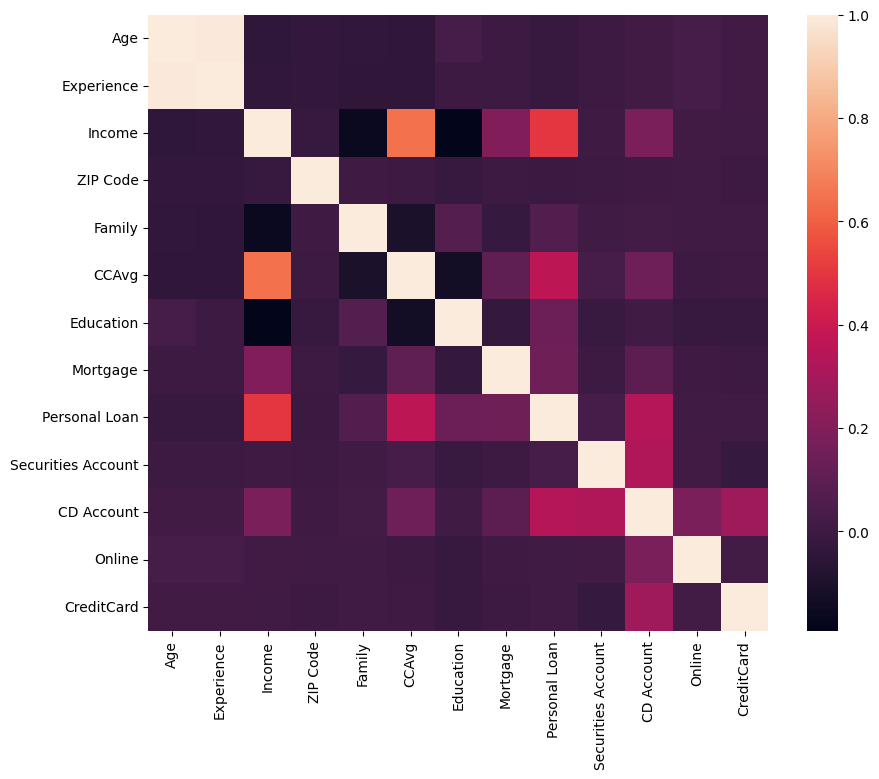

MOST_CORRELATED_PAIR: Age, Experience
LEAST_CORRELATED_FEATURE: ZIP Code
EXPERIENCE_MEAN_AFTER_SHIFT: 23.196
CCAVG_MEAN_AFTER_TRANSFORM: 23.062


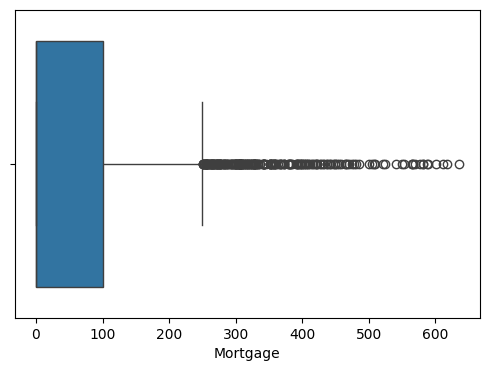

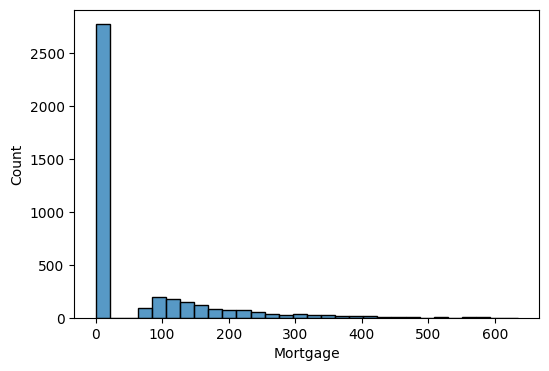

MORTGAGE_OUTLIERS_COUNT: 83
N_ROWS_AFTER_OUTLIER_REMOVAL: 3917
GINI_F1: 0.908
ENTROPY_F1: 0.899


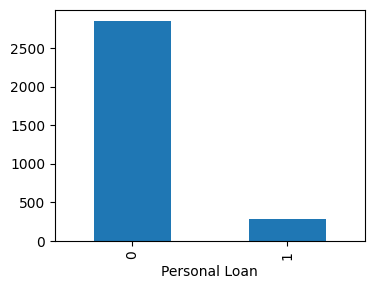

TRAIN_CLASS_0_SHARE: 0.911
GINI_BAL_F1: 0.913


KeyboardInterrupt: 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
# from imblearn.over_sampling import SMOTE


data_path = "Bank_Personal_Loan_Modelling_train.csv"
df = pd.read_csv(data_path)

df = df.drop(columns=["ID"])

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True))
plt.show()

corr = df.corr(numeric_only=True)
corr_no_diag = corr.where(~np.eye(corr.shape[0], dtype=bool))
most_corr_pair = corr_no_diag.abs().stack().idxmax()
most_corr_pair = tuple(sorted(most_corr_pair))
print("MOST_CORRELATED_PAIR:", f"{most_corr_pair[0]}, {most_corr_pair[1]}")

abs_corr_sum = corr.abs().sum().sort_values()
least_corr_feature = abs_corr_sum.index[0]
print("LEAST_CORRELATED_FEATURE:", least_corr_feature)

df = df.drop(columns=[least_corr_feature])


df["Experience"] = df["Experience"] - df["Experience"].min()
exp_mean = df["Experience"].mean()
print("EXPERIENCE_MEAN_AFTER_SHIFT:", round(exp_mean, 3))

df["CCAvg"] = df["CCAvg"] * 12
ccavg_mean = df["CCAvg"].mean()
print("CCAVG_MEAN_AFTER_TRANSFORM:", round(ccavg_mean, 3))


plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Mortgage"])
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["Mortgage"], bins=30)
plt.show()

mortgage_z = zscore(df["Mortgage"])
outliers_mask = np.abs(mortgage_z) > 3
n_outliers = int(outliers_mask.sum())
print("MORTGAGE_OUTLIERS_COUNT:", n_outliers)

df = df[~outliers_mask]
rows_after = df.shape[0]
print("N_ROWS_AFTER_OUTLIER_REMOVAL:", rows_after)


X = df.drop(columns=["Personal Loan"])
y = df["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=105,
    stratify=y
)

clf_gini = DecisionTreeClassifier(random_state=105, criterion="gini")
clf_gini.fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)
f1_gini = f1_score(y_test, y_pred_gini)
print("GINI_F1:", round(f1_gini, 3))

clf_entropy = DecisionTreeClassifier(random_state=105, criterion="entropy")
clf_entropy.fit(X_train, y_train)
y_pred_entropy = clf_entropy.predict(X_test)
f1_entropy = f1_score(y_test, y_pred_entropy)
print("ENTROPY_F1:", round(f1_entropy, 3))


plt.figure(figsize=(4, 3))
y_train.value_counts().sort_index().plot(kind="bar")
plt.show()

share_class0 = (y_train == 0).mean()
print("TRAIN_CLASS_0_SHARE:", round(share_class0, 3))

clf_gini_bal = DecisionTreeClassifier(
    random_state=105,
    criterion="gini",
    class_weight="balanced"
)
clf_gini_bal.fit(X_train, y_train)
f1_gini_bal = f1_score(y_test, clf_gini_bal.predict(X_test))
print("GINI_BAL_F1:", round(f1_gini_bal, 3))

clf_entropy_bal = DecisionTreeClassifier(
    random_state=105,
    criterion="entropy",
    class_weight="balanced"
)
clf_entropy_bal.fit(X_train, y_train)
f1_entropy_bal = f1_score(y_test, clf_entropy_bal.predict(X_test))
print("ENTROPY_BAL_F1:", round(f1_entropy_bal, 3))


# smote = SMOTE(random_state=105)
# X_train_up, y_train_up = smote.fit_resample(X_train, y_train)

# n_class1_up = int((y_train_up == 1).sum())
# print("N_CLASS_1_AFTER_UPSAMPLING:", n_class1_up)

# clf_gini_up = DecisionTreeClassifier(random_state=105, criterion="gini")
# clf_gini_up.fit(X_train_up, y_train_up)
# f1_gini_up = f1_score(y_test, clf_gini_up.predict(X_test))
# print("GINI_UP_F1:", round(f1_gini_up, 3))

# clf_entropy_up = DecisionTreeClassifier(random_state=105, criterion="entropy")
# clf_entropy_up.fit(X_train_up, y_train_up)
# f1_entropy_up = f1_score(y_test, clf_entropy_up.predict(X_test))
# print("ENTROPY_UP_F1:", round(f1_entropy_up, 3))


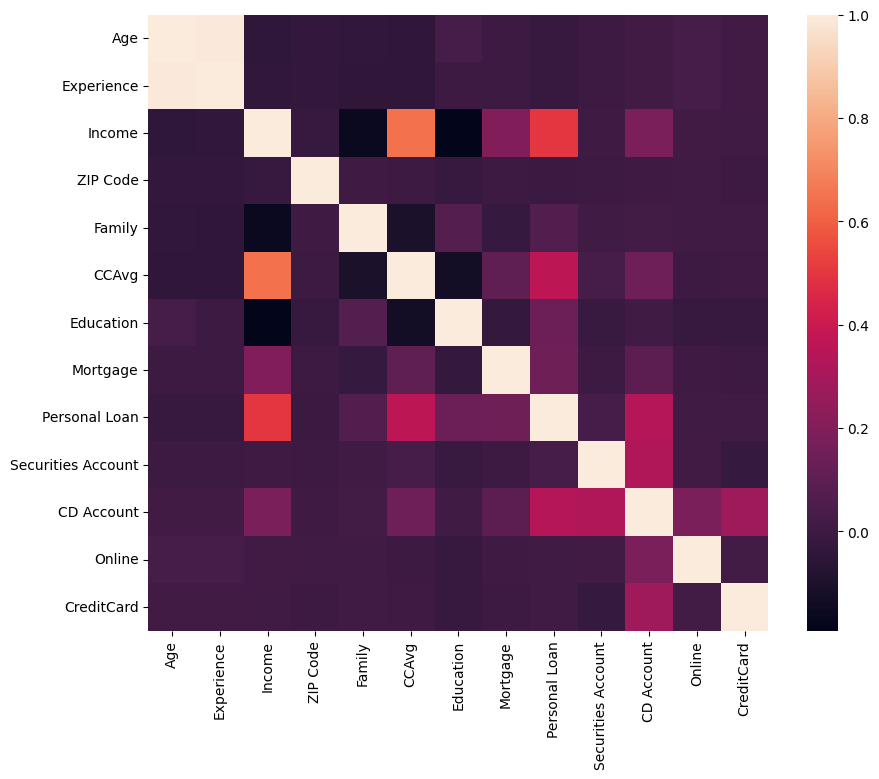

MOST_CORRELATED_PAIR: Age, Experience
LEAST_CORRELATED_FEATURE: ZIP Code
EXPERIENCE_MEAN_AFTER_SHIFT: 23.196
CCAVG_MEAN_AFTER_TRANSFORM: 23.062


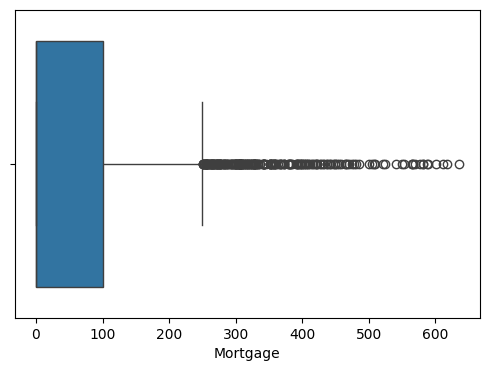

MORTGAGE_OUTLIERS_COUNT: 83
N_ROWS_AFTER_OUTLIER_REMOVAL: 3917
GINI_F1: 0.908
ENTROPY_F1: 0.899
TRAIN_CLASS_0_SHARE: 0.911
GINI_BAL_F1: 0.913
ENTROPY_BAL_F1: 0.92
N_CLASS_1_AFTER_UPSAMPLING: 2855
GINI_UP_F1: 0.848
ENTROPY_UP_F1: 0.868


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


df0 = pd.read_csv("Bank_Personal_Loan_Modelling_train.csv")

df_corr = df0.drop(columns=["ID"])
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr())
plt.show()

mc = df_corr.corr().where(~np.eye(df_corr.shape[1], dtype=bool))
pair = mc.abs().stack().idxmax()
pair = tuple(sorted(pair))
print("MOST_CORRELATED_PAIR:", f"{pair[0]}, {pair[1]}")

least = df_corr.corr().abs().sum().sort_values().index[0]
print("LEAST_CORRELATED_FEATURE:", least)


df1 = df0.drop(columns=["ID", least])
df1["Experience"] = df1["Experience"] - df1["Experience"].min()
print("EXPERIENCE_MEAN_AFTER_SHIFT:", round(df1["Experience"].mean(), 3))

df1["CCAvg"] = df1["CCAvg"] * 12
print("CCAVG_MEAN_AFTER_TRANSFORM:", round(df1["CCAvg"].mean(), 3))


plt.figure(figsize=(6, 4))
sns.boxplot(x=df1["Mortgage"])
plt.show()

zs = zscore(df1["Mortgage"])
mask = np.abs(zs) > 3
print("MORTGAGE_OUTLIERS_COUNT:", int(mask.sum()))

df2 = df1.loc[~mask]
print("N_ROWS_AFTER_OUTLIER_REMOVAL:", df2.shape[0])


X = df2.drop(columns=["Personal Loan"])
y = df2["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=105, stratify=y
)

clf1 = DecisionTreeClassifier(random_state=105, criterion="gini")
clf1.fit(X_train, y_train)
print("GINI_F1:", round(f1_score(y_test, clf1.predict(X_test)), 3))

clf2 = DecisionTreeClassifier(random_state=105, criterion="entropy")
clf2.fit(X_train, y_train)
print("ENTROPY_F1:", round(f1_score(y_test, clf2.predict(X_test)), 3))


print("TRAIN_CLASS_0_SHARE:", round((y_train == 0).mean(), 3))

clf3 = DecisionTreeClassifier(random_state=105, criterion="gini", class_weight="balanced")
clf3.fit(X_train, y_train)
print("GINI_BAL_F1:", round(f1_score(y_test, clf3.predict(X_test)), 3))

clf4 = DecisionTreeClassifier(random_state=105, criterion="entropy", class_weight="balanced")
clf4.fit(X_train, y_train)
print("ENTROPY_BAL_F1:", round(f1_score(y_test, clf4.predict(X_test)), 3))


sm = SMOTE(random_state=105)
X_up, y_up = sm.fit_resample(X_train, y_train)
print("N_CLASS_1_AFTER_UPSAMPLING:", int((y_up == 1).sum()))

clf5 = DecisionTreeClassifier(random_state=105, criterion="gini")
clf5.fit(X_up, y_up)
print("GINI_UP_F1:", round(f1_score(y_test, clf5.predict(X_test)), 3))

clf6 = DecisionTreeClassifier(random_state=105, criterion="entropy")
clf6.fit(X_up, y_up)
print("ENTROPY_UP_F1:", round(f1_score(y_test, clf6.predict(X_test)), 3))
